#### SUM main + ExMAS + MSA + KPI + ASC


In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from shapely.geometry import Point

import ExMAS.utils
from ExMAS.utils import inData
from src import functions as fncs

import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [2]:
OTP_API = "http://localhost:8080/otp/routers/default/plan"
params = ExMAS.utils.get_config('data/configs/default_SUM.json')

In [3]:
# Load graph
inData = ExMAS.utils.load_G(inData, params, stats=True)

In [4]:
# Read files with data: Krakow zones and their centroids
gdf_zones = gpd.read_file('data/krk.geojson')
gdf_centroid = gpd.read_file('data/krk_centroid.geojson')

<Axes: >

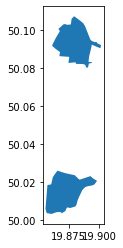

In [5]:
# Read SUM areas: Bronowice and Skotniki
gdf_areas = gpd.read_file('data/sum_areas/sum_areas_B+S.shp')
gdf_areas = gdf_areas.rename(columns={"nazwa": "name"})
# transform coordinate system to EPSG:4326
gdf_areas = gdf_areas.to_crs(4326) 
gdf_areas.plot()

In [6]:
gdf_areas

,name,geometry
0,Bronowice Wielkie,"POLYGON ((19.87805 50.08284, 19.87469 50.08260..."
1,Skotniki,"POLYGON ((19.88842 50.01723, 19.88734 50.01662..."


In [7]:
# Read ODMs and calculate the "probabilities" for destinations
od = pd.read_excel('data/krk_ODM.xlsx', 'AM_peak_PuT', skiprows=[1, 2])
od.rename(columns = {'464 x 464' : 'zone_NO', 'Unnamed: 2': 'sum'}, inplace = True)
od.drop(od.filter(regex="Unname"), axis=1, inplace=True)
od.reset_index(drop=True, inplace=True)
od[0:] = od[:].astype(float)
od['zone_NO'] = od['zone_NO'].astype(int)
# filter OD zone number to match city zones and recalculate sum for origins
od = od.loc[od['zone_NO'].isin(gdf_zones['NO']), ['zone_NO', 'sum'] + gdf_zones['NO'].to_list()]
od['sum'] = od.loc[:, 1:].sum(axis=1)
# calculate destination "probability" for each origin point
od_probs = pd.concat([od['zone_NO'], 
            od.loc[:, 'sum':].astype('float64').divide(od.loc[:, 'sum'].astype('float64'), axis=0)], axis=1)

In [8]:
# Read demographic of the city, clean data
df_demo = pd.read_csv('data/krk_demographic.csv', index_col=0)
df_demo = df_demo.rename(columns={"adr_pelny": "address", "ogolem": "total" })
# assign new coordinates for addresses from outside the city zone
filter = ['STAREGO DĘBU' in i for i in df_demo['address']]
df_demo.loc[filter, 'x'], df_demo.loc[filter, 'y'] = 19.872702, 50.100578
# assign zone number to each address point
df_demo['zone_NO'] = df_demo.apply(lambda row: 
                                   fncs.find_containing_polygon(Point(row['x'], row['y']), gdf_zones), axis=1)
# remove the trips with nan zone
df_demo.dropna(subset='zone_NO', inplace=True, ignore_index=True)

In [9]:
# Chosen hub locations for each area
hubs = {"Bronowice Wielkie": (19.88192, 50.08179), "Skotniki": (19.88948, 50.01844)}

##### Main simulations: evaluate primary indicators 

(degree = 6, N = 100, max_iter = 30, results_period = 20)
- Probability of choosing feeder
- Reduction in waiting times for PT
- Feeder attractiveness
- Added value

In [13]:
results = fncs.simulate_MSA(gdf_areas, df_demo, gdf_centroid, od, od_probs, hubs, inData, params, OTP_API,
                            degree=6, N=100, max_iter=30, ASC=2.2, results_period=20)

##### Save results

For each area, Bronowice Wielkie and Skotniki:
<br>dataframes "avg_sim_res" contain average main results for such variables:
- tw_PT_OD - waiting time for PT from O to D
- tw_PT_HD - waiting time for PT from H to D
- u_PT_OD - utility for PT option from O to D
- u_PT_HD - utility for PT option from H to D 
- u_SUM_OD - utility for feeder option from O to D
- p_SUM - probability of choosing feeder

In [40]:
results['Bronowice Wielkie']['avg_sim_res'].to_csv("results/main_results/avg_sim_res_b.csv")
results['Skotniki']['avg_sim_res'].to_csv("results/main_results/avg_sim_res_s.csv")

dataframes "sum_res" contain results for 1 area sample replication:
<br>origin_x, origin_y, destination_x, destination_y, treq, origin, destination, 
<br>dist, ttrav, tarr, t_expected, u_PT_OD, u_PT_HD, u_SUM_OD, p_SUM, nTrips

In [42]:
results['Bronowice Wielkie']['sum_res'].to_csv("results/main_results/sum_res_b.csv")
results['Skotniki']['sum_res'].to_csv("results/main_results/sum_res_s.csv")

dataframes "kpis_res" contain results for KPI's calculated by ExMAS framework after system stabilization

In [43]:
results['Bronowice Wielkie']['kpis_res'].to_csv("results/main_results/kpis_res_b.csv")
results['Skotniki']['kpis_res'].to_csv("results/main_results/kpis_res_s.csv")

dataframes "avg_times" contain average expected times for each area sample replication

In [ ]:
results['Bronowice Wielkie']['avg_times'].to_csv("results/main_results/avg_times_b.csv")
results['Skotniki']['avg_times'].to_csv("results/main_results/avg_times_s.csv")

dataframes "converged_is" contain iteration number, when the convergence occured

In [52]:
df_converged_indxs = pd.DataFrame()
df_converged_indxs['Bronowice Wielkie'] = results['Bronowice Wielkie']['converged_is']
df_converged_indxs['Skotniki'] = results['Skotniki']['converged_is']
df_converged_indxs.to_csv("results/main_results/converged_indxs.csv")

In [38]:
# Average iteration with convergence
idx_converged = pd.read_csv("results/main_results/converged_indxs.csv", index_col=0)
print('Bronowice Wielkie', idx_converged['Bronowice Wielkie'].mean(), 
      'Skotniki', idx_converged['Skotniki'].mean())

15.02 16.69


avg_ts_sh - average times only for travelers who share trip
<br> avg_ts_pt - average times for travelers using PT

In [ ]:
results['Bronowice Wielkie']['avg_ts_sh'].to_csv("results/main_results/avg_ts_sh_b.csv")
results['Skotniki']['avg_ts_sh'].to_csv("results/main_results/part_res/avg_ts_sh_s.csv")

results['Bronowice Wielkie']['avg_ts_pt'].to_csv("results/main_results/part_res/avg_ts_pt_b.csv")
results['Skotniki']['avg_ts_pt'].to_csv("results/main_results/part_res/avg_ts_pt_s.csv")

#### Read results, calculate main indicators

In [197]:
avg_sim_res_b = pd.read_csv("results/main_results/avg_sim_res_b.csv", index_col=0)
avg_sim_res_s = pd.read_csv("results/main_results/avg_sim_res_s.csv", index_col=0)

avg_sim_res_b['Area']='Bronowice Wielkie'
avg_sim_res_s['Area']='Skotniki'
avg_sim_res_b_s = pd.concat([avg_sim_res_b, avg_sim_res_s])

avg_sim_res_b_s['Prob of choosing feeder'] = avg_sim_res_b_s['p_SUM']
avg_sim_res_b_s['Reduction in waiting times for PT'] = avg_sim_res_b_s['tw_PT_OD'] - avg_sim_res_b_s['tw_PT_HD']
avg_sim_res_b_s['Feeder attractiveness'] = avg_sim_res_b_s['u_PT_OD'] - avg_sim_res_b_s['u_SUM_OD']
mu = -0.1
avg_sim_res_b_s['Added value'] = np.log(np.exp(mu * avg_sim_res_b_s['u_PT_OD'])+ \
                                 np.exp(mu * avg_sim_res_b_s['u_SUM_OD']) - np.log(np.exp(mu * avg_sim_res_b_s['u_PT_OD'])))

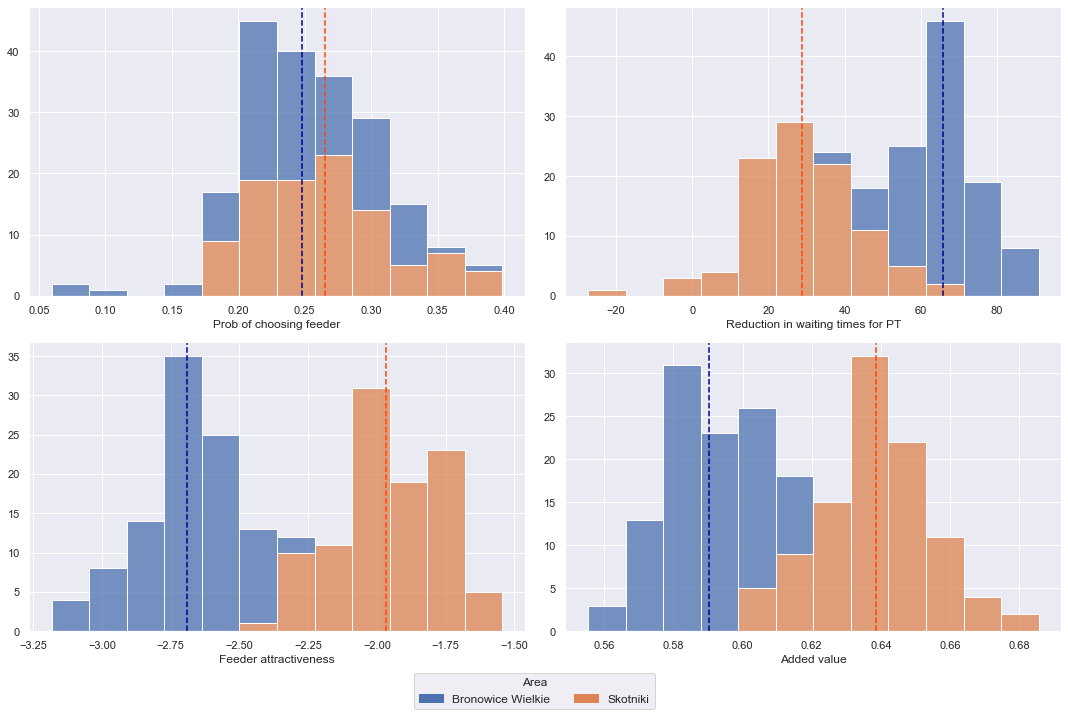

In [223]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
means = avg_sim_res_b_s.groupby('Area').mean()
cols = avg_sim_res_b_s.columns[-4:]   

ys_b = avg_sim_res_b_s[avg_sim_res_b_s['Area'] == 'Bronowice Wielkie']
ys_s = avg_sim_res_b_s[avg_sim_res_b_s['Area'] == 'Skotniki']

for col, a in zip(cols, ax.flat):
    sns.histplot(data=avg_sim_res_b_s, x=col,  hue='Area', bins=12, ax=a,
                 multiple="stack", edgecolor='white', legend=False) 
    # a.hist(ys_b[col], edgecolor='white', bins=7)
    # a.hist(ys_s[col], edgecolor='white', bins=7)
    a.set_ylabel('')
    a.axvline(means.loc['Bronowice Wielkie', col], linestyle='--', color="darkblue")
    a.axvline(means.loc['Skotniki', col], linestyle='--', color="orangered")

# custom legend
legend_handles = [
    mpatches.Patch(color=sns.color_palette()[0], label='Bronowice Wielkie'),
    mpatches.Patch(color=sns.color_palette()[1], label='Skotniki')
]
plt.figlegend(handles=legend_handles, title='Area', 
              loc='lower center', ncol=2, fontsize=12)

# plt.savefig('results/images/main_indicators.png', dpi=300)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

Calculate mean values (of 100 averages for each sample) for each indicator and evaluate variance

In [201]:
means = means[means.columns[-4:]]
vars_b = avg_sim_res_b_s.loc[avg_sim_res_b_s['Area'] == 'Bronowice Wielkie'][avg_sim_res_b_s.columns[-4:]].var()
vars_s = avg_sim_res_b_s.loc[avg_sim_res_b_s['Area'] == 'Skotniki'][avg_sim_res_b_s.columns[-4:]].var()
variances = pd.concat([vars_b, vars_s], axis=1)
variances = variances.T
means.insert(1, 'prob var', variances['Prob of choosing feeder'].values)
means.insert(3, 'reduction in waiting t var', variances['Reduction in waiting times for PT'].values)
means.insert(5, 'attractiveness var', variances['Feeder attractiveness'].values)

means['added value var'] = variances['Added value'].values
means = round(means, 4)
means

,Prob of choosing feeder,prob var,Reduction in waiting times for PT,reduction in waiting t var,Feeder attractiveness,attractiveness var,Added value,added value var
Area,,,,,,,,
Bronowice Wielkie,0.2481,0.0030,65.9044,107.6911,-2.6898,0.0340,0.5904,0.0002
Skotniki,0.2651,0.0027,28.9247,224.9553,-1.9656,0.0357,0.6386,0.0003


In [136]:
means.to_csv("results/main_results/main_indicators.csv")

Evaluation of additional KPI's (obtained by ExMAS) 

In [10]:
kpis_b = pd.read_csv("results/main_results/kpis_res_b.csv", index_col=0)
kpis_b = kpis_b.T.reset_index(drop=True)
kpis_b = fncs.calc_KPIs(kpis_b)

kpis_s = pd.read_csv("results/main_results/kpis_res_s.csv", index_col=0)
kpis_s = kpis_s.T.reset_index(drop=True)
kpis_s = fncs.calc_KPIs(kpis_s)

kpis_b['Area']='Bronowice Wielkie'
kpis_s['Area']='Skotniki'
# rename columns to plot
kpis_b.rename(columns={"del_VehHourTrav": u"Δ Vehicle hours travelled", 
                         "del_PassHourTrav": u"Δ Passenger hours travelled"}, inplace=True)
kpis_s.rename(columns={"del_VehHourTrav": u"Δ Vehicle hours travelled", 
                         "del_PassHourTrav": u"Δ Passenger hours travelled"}, inplace=True)
kpis_b_s = pd.concat([kpis_b, kpis_s])

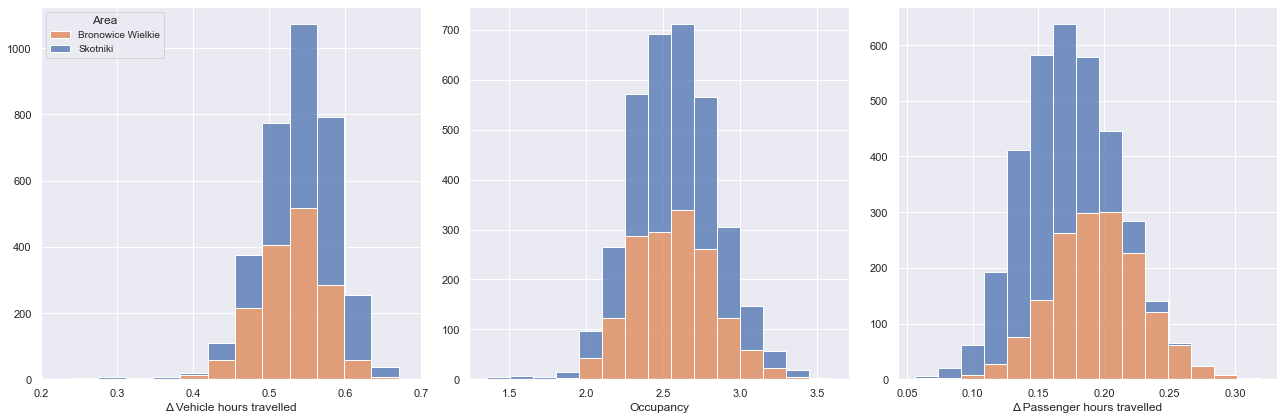

In [18]:
cols = ['Δ Vehicle hours travelled', 'Occupancy', 'Δ Passenger hours travelled']
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, (col, a) in enumerate(zip(cols, ax.flat)):
    if i == 0:
        a.set_xlim(0.2, 0.7)
        # add legend only to the first subplot
        sns.histplot(data=kpis_b_s, x=col, hue='Area', bins=15, ax=a, 
                     multiple="stack", edgecolor='white', legend=True)  
        a.legend(labels=['Bronowice Wielkie', 'Skotniki'], title='Area', loc='upper left', fontsize=10)
    else:
        # hide legend for other subplots
        sns.histplot(data=kpis_b_s, x=col, hue='Area', bins=15, ax=a, 
                     multiple="stack", edgecolor='white', legend=False)  
    a.set_ylabel('')

# plt.savefig('results/images/kpis_hists_sns.png', dpi=300)
plt.tight_layout()
plt.show()

In [258]:
df_sum_b = pd.read_csv("results/main_results/part_res/sum_res_b.csv", index_col=0)
df_sum_s = pd.read_csv("results/main_results/part_res/sum_res_s.csv", index_col=0)

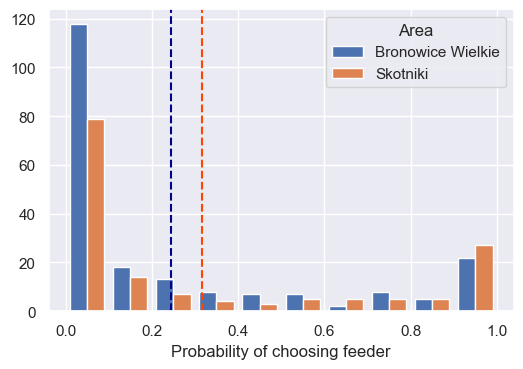

In [261]:
p_sum_b = df_sum_b.p_SUM
p_sum_s = df_sum_s.p_SUM

plt.figure(dpi=100)
plt.hist([p_sum_b, p_sum_s], edgecolor='white', 
        label=['Bronowice Wielkie', 'Skotniki'])
plt.axvline(p_sum_b.mean(), linestyle='--', color="darkblue")
plt.axvline(p_sum_s.mean(), linestyle='--', color="orangered")
plt.xlabel('Probability of choosing feeder', fontsize=12)
plt.legend(title='Area')
# plt.savefig('results/images/prob_sum_res.png', dpi=300)
plt.show()

Analyse average times

In [288]:
avg_ts_b = pd.read_csv("results/main_results/avg_times_b.csv", index_col=0)
avg_ts_s = pd.read_csv("results/main_results/avg_times_s.csv", index_col=0)

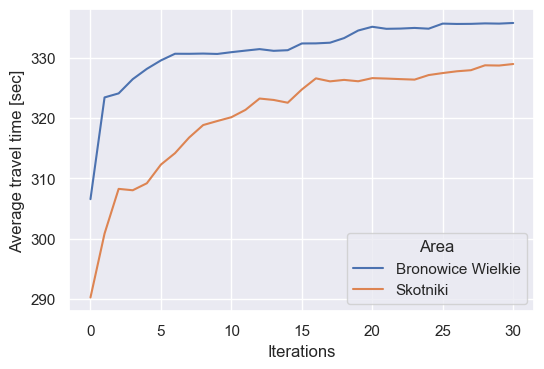

In [372]:
# average t_expexted after applying MSA for 30 iterations
tb = avg_ts_b.iloc[:, 10]
ts = avg_ts_s.iloc[:, 10]

plt.figure(dpi=100)
plt.plot(tb, label='Bronowice Wielkie')
plt.plot(ts, label='Skotniki')
plt.xlabel('Iterations')
plt.ylabel('Average travel time [sec]')
plt.legend(title='Area')
# plt.savefig('results/images/avg_times_10.png', dpi=300)
plt.show()

Analyze system convergence indexes

In [321]:
idx_converged = pd.read_csv("results/main_results/converged_indxs.csv", index_col=0)
print(idx_converged['Bronowice Wielkie'].mean(), idx_converged['Skotniki'].mean())

16.51 16.12


In [323]:
idx_converged[idx_converged['Bronowice Wielkie'] == 0]

,Bronowice Wielkie,Skotniki
14,0,10
21,0,0
32,0,26
40,0,0
45,0,25


In [318]:
idx_converged[idx_converged['Skotniki'] == 0]

,index,Bronowice Wielkie,Skotniki
15,15,14,0
17,17,13,0
21,21,0,0
23,23,19,0
25,0,19,0
27,2,24,0
31,6,15,0
33,8,21,0
36,11,20,0
40,15,0,0


Analyze travel times for two transport modes: feeder and PT 

In [338]:
pt_ts_b = pd.read_csv("results/main_results/avg_ts_pt_b.csv", index_col=0)
sh_ts_b = pd.read_csv("results/main_results/avg_ts_sh_b.csv", index_col=0)

pt_ts_s = pd.read_csv("results/main_results/avg_ts_pt_s.csv", index_col=0)
sh_ts_s = pd.read_csv("results/main_results/avg_ts_sh_s.csv", index_col=0)

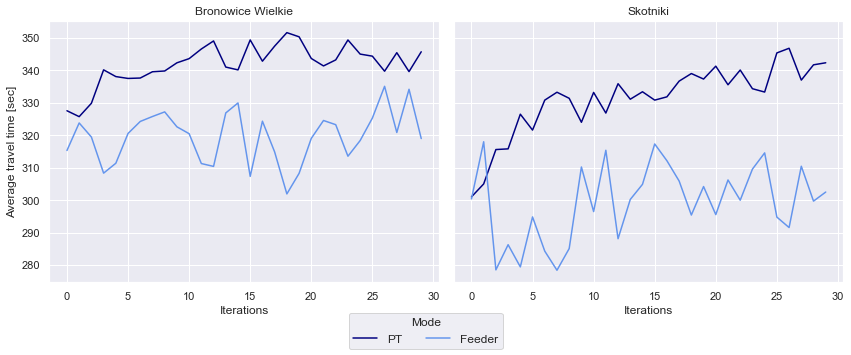

In [366]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Bronowice
ax[0].plot(pt_ts_b.iloc[:, 7], label='PT', color='navy')
ax[0].plot(sh_ts_b.iloc[:, 7], label='Feeder', color='cornflowerblue')
ax[0].set_title("Bronowice Wielkie")
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Average travel time [sec]')

# Skotniki
ax[1].plot(pt_ts_s.iloc[:, 10], label='PT', color='navy')
ax[1].plot(sh_ts_s.iloc[:, 10], label='Feeder', color='cornflowerblue')
ax[1].set_title("Skotniki")
ax[1].set_xlabel('Iterations')

# plt.xlabel('Iterations')
fig.legend(labels=['PT', 'Feeder'], title='Mode', loc='lower center', ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.show()

### Analyze the dependency of main indicators on ASC

In [ ]:
# ! run 5 simulations (N=5 area sample replications) of shared trips (degree=6) with varying ASCs [0, 5] for n=50 asc sample
# Simulations were performed on the processor 3,8 GHz 8-Core Intel Core i7 - the duration is 9893m 46.1s (164.88h or 6.87d)

max_ASC = 5
n = 50
count = 1
total_res = {}
res_b, res_s = {}, {}

for asc in np.linspace(0.00001, max_ASC, n):
    print(count, "ASC", asc)
    count += 1
    res = fncs.simulate_MSA(gdf_areas, df_demo, gdf_centroid, od, od_probs, hubs, inData, params, OTP_API, 
                    degree=6, N=5, max_iter=30, ASC=asc, results_period=0)
    
    res_b[asc] = res['Bronowice Wielkie']['avg_sim_res']
    res_s[asc] = res['Skotniki']['avg_sim_res']

total_res['Bronowice Wielkie'] = res_b
total_res['Skotniki'] = res_s

In [ ]:
# assign ASC column to combined dataframes

dict_b = total_res['Bronowice Wielkie'].copy()
combined_df_b = pd.concat(
    [df.assign(ASC=key) for key, df in dict_b.items()], ignore_index=True)
dict_s = total_res['Skotniki'].copy()
combined_df_s = pd.concat(
    [df.assign(ASC=key) for key, df in dict_s.items()], ignore_index=True)

In [ ]:
# save to CSV
combined_df_b.to_csv('results/main_results/5_res_asc_indicators_b.csv', index=False)
combined_df_s.to_csv('results/main_results/5_res_asc_indicators_s.csv', index=False)

In [373]:
# read from csv, plot graphs
b_df = pd.read_csv("results/main_results/5_res_asc_indicators_b.csv")
s_df = pd.read_csv("results/main_results/5_res_asc_indicators_s.csv")

In [379]:
b_df['Area']='Bronowice Wielkie'
s_df['Area']='Skotniki'
b_s_df = pd.concat([b_df, s_df])
b_s_df['Prob of choosing feeder'] = b_s_df['p_SUM']
b_s_df['Reduction in waiting times for PT'] = b_s_df['tw_PT_OD'] - b_s_df['tw_PT_HD']
b_s_df['Feeder attractiveness'] = b_s_df['u_PT_OD'] - b_s_df['u_SUM_OD']
mu = -0.1
b_s_df['Added value'] = np.log(np.exp(mu * b_s_df['u_PT_OD']) +\
                               np.exp(mu * b_s_df['u_SUM_OD']) - np.log(np.exp(mu * b_s_df['u_PT_OD'])))

Scatterplot with the line as an average of 5 measures

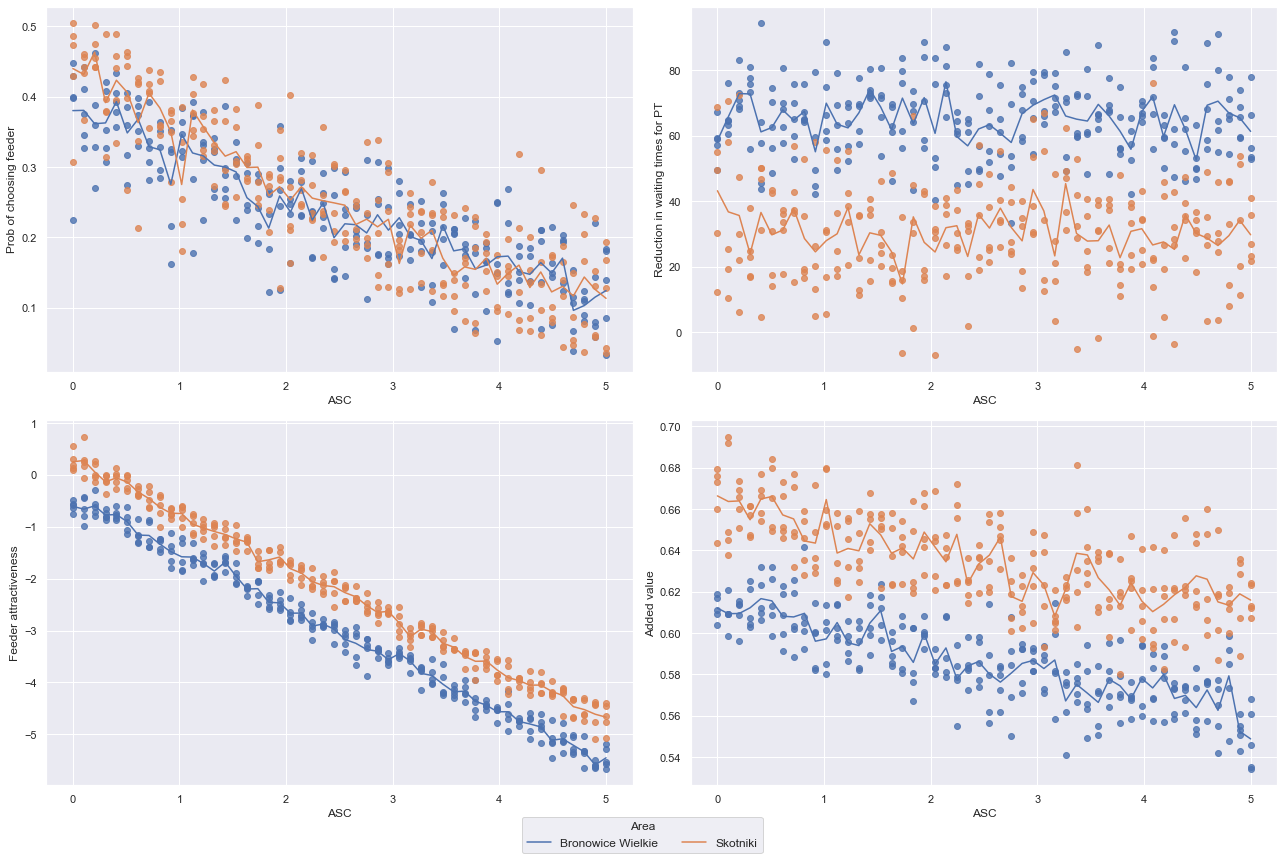

In [406]:
max_ASC = 5
n = 50
plt.figure(figsize=(18, 12))
lines = []
xs = list(np.linspace(0, max_ASC, n))
xs_scatter = b_df['ASC'].values
ys_b = b_s_df[b_s_df['Area'] == 'Bronowice Wielkie']
ys_s = b_s_df[b_s_df['Area'] == 'Skotniki']

for idx, col in enumerate(cols, start=1):
    plt.subplot(2, 2, idx)
    plt.scatter(xs_scatter, ys_b[col].values, alpha=0.8)
    plt.scatter(xs_scatter, ys_s[col].values, alpha=0.8)
    b_line, = plt.plot(xs, ys_b.groupby(by=['ASC'])[col].mean().values, label='Bronowice Wielkie')
    s_line, = plt.plot(xs, ys_s.groupby(by=['ASC'])[col].mean().values, label='Skotniki')
    
    # plt.title(f"{col} vs ASC")
    plt.xlabel("ASC", fontsize=12)
    plt.ylabel(col, fontsize=12)
    if idx == 1:
        lines.extend([b_line, s_line])

plt.figlegend(handles=lines, labels=['Bronowice Wielkie', 'Skotniki'], title='Area', 
              loc='lower center', ncol=2, fontsize=12)

# plt.savefig('results/images/asc_vs_indicators_5_plt.png', dpi=300)
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()